In [988]:
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go 
import scikitplot as skplt


import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
py.init_notebook_mode(connected=True)

from sqlalchemy import create_engine
import pymysql

import numpy as np
import pandas as pd
import sklearn as sk

from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [1305]:
uri_direct = 'mysql+pymysql://root:@localhost:3306/bank'
engine_direct = create_engine(uri_direct)
con = engine_direct.connect()
df = pd.read_sql('''
    SELECT * 
    FROM mldataset_2;
''',con=con)


In [1306]:
df['status']=df['status'].astype('int64')
df['gds2']=df['loanpmt']/df['avgsal']
df['gender']=pd.get_dummies(df['gender'],drop_first=True)
df = df.drop(columns='GDS')

In [1307]:
df

,status,dur,loanpmt,avgbal,minbal,maxbal,dcovratio,num_cashwd,avg_cashwd,num_cashdep,...,acholders,yearswbank,gender,aplicant_age,agebracket,urbanratio,avgsal,avgunemprate,selfemprate,gds2
0,0,12.0,6908.0,57141.8016,900,107681,8.271830,57,9511.9649,4,...,2,482,1,22,2,60.8,8208,2.075,0.155,0.841618
1,0,24.0,2154.0,58226.5196,600,124339,27.031810,53,12739.0189,31,...,1,396,0,26,3,100.0,10673,5.095,0.100,0.201818
2,0,12.0,4502.0,36480.2381,1000,81706,8.103118,66,8161.1061,1,...,1,675,1,28,3,53.8,8814,5.250,0.107,0.510778
3,0,60.0,501.0,37213.4194,500,69383,74.278282,65,4522.0769,24,...,1,651,1,45,5,36.9,8594,1.815,0.112,0.058296
4,0,48.0,2820.0,64881.4416,200,146480,23.007603,45,12188.3333,21,...,1,363,1,21,2,52.0,8187,5.140,0.094,0.344449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0,60.0,5291.0,64978.1655,700,135890,12.280886,67,13575.9851,34,...,1,499,1,23,2,52.0,8187,5.140,0.094,0.646268
678,0,24.0,1632.0,55438.8148,300,81496,33.969862,25,6487.6000,13,...,1,347,0,19,2,63.4,9920,2.565,0.130,0.164516
679,0,60.0,4674.0,38619.0849,1000,102466,8.262534,59,7045.8475,28,...,1,620,0,46,5,100.0,9897,1.780,0.140,0.472264
680,0,60.0,6998.0,59352.6667,200,104040,8.481376,6,32766.6667,2,...,2,156,0,50,5,100.0,12541,0.360,0.167,0.558010


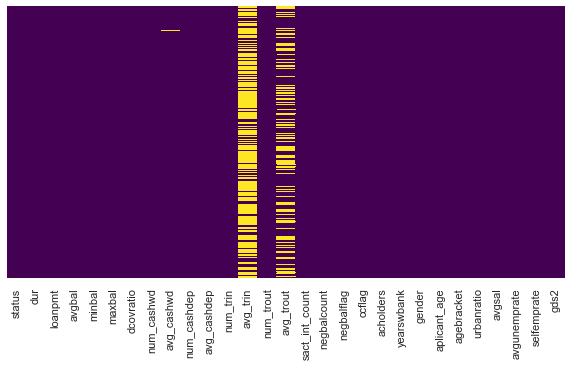

In [1308]:
#missing values visual
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False, cmap='viridis', ax=ax); 

In [1370]:
def imputator(dfname):
    imputer = KNNImputer() 
    imputer.fit(dfname)
    X = imputer.transform(dfname)
    df_imputed = pd.DataFrame(X, columns=dfname.columns, index=dfname.index)
    return df_imputed

def imputator_a(array):
    imputer = KNNImputer() 
    imputer.fit(array)
    array_imputed = imputer.transform(array)
    return array_imputed

def sampler(X_train, y_train):
    sampler = RandomOverSampler(random_state=42)
    X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
    return X_train_sampled, y_train_sampled

In [1542]:
X = df.drop(columns=['status','loanpmt','avgsal','aplicant_age'])
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_s, y_train_s = sampler(imputator(X_train), y_train)
X_test_imputed = imputator(X_test)

numpipe = Pipeline([
    ('scaler', MinMaxScaler())
])
numcols = X.drop(columns=['dur','agebracket']).columns.to_list()
catcols = ['dur','agebracket']
pipeline = ColumnTransformer([
        ('num',numpipe, numcols),
        ('cat',OneHotEncoder(), catcols)
])
X_train_prep = pipeline.fit_transform(X_train_s)
X_test_prep = pipeline.fit_transform(X_test_imputed)

In [1506]:
# numpipe = Pipeline([
#     ('scaler', MinMaxScaler())
# ])
# numcols = X.drop(columns=['dur','agebracket']).columns.to_list()
# catcols = ['dur','agebracket']
# pipeline = ColumnTransformer([
#         ('num',numpipe, numcols),
#         ('cat',OneHotEncoder(), catcols)
# ])
# X_train_prep = pipeline.fit_transform(X_train_s)
# X_test_prep = pipeline.fit_transform(X_test_imputed)

In [1543]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(GB,X_train_prep,y_train_s, cv=5,scoring='recall')
scores

array([1., 1., 1., 1., 1.])

# Model Selection

In [1544]:
RF=RandomForestClassifier()
DT=DecisionTreeClassifier()
LR=LogisticRegression()
GB = GradientBoostingClassifier()
models_dict = {
            'LogisticRegression':LR,
            'DecisionTree':DT,
            'RandomForest':RF,
            'GradientBoosting':GB
}

In [1545]:
m_scores=[]
clf_reports={}
for m in models_dict.keys():
    model = models_dict[m]
    model.fit(X_train_prep,y_train_s)
    y_pred= model.predict(X_test_prep)
    m_scores.append([m,accuracy_score(y_test, y_pred)])
    clf_reports[m]=classification_report(y_test,y_pred)
[print(i) for i in m_scores]

['LogisticRegression', 0.7883211678832117]
['DecisionTree', 0.7956204379562044]
['RandomForest', 0.927007299270073]
['GradientBoosting', 0.8613138686131386]


[None, None, None, None]

In [1546]:
for m in models_dict.keys():
    print(m,'\n',clf_reports[m])

LogisticRegression 
               precision    recall  f1-score   support

           0       0.98      0.78      0.87       122
           1       0.33      0.87      0.47        15

    accuracy                           0.79       137
   macro avg       0.65      0.82      0.67       137
weighted avg       0.91      0.79      0.82       137

DecisionTree 
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       122
           1       0.19      0.27      0.22        15

    accuracy                           0.80       137
   macro avg       0.55      0.56      0.55       137
weighted avg       0.83      0.80      0.81       137

RandomForest 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       122
           1       0.69      0.60      0.64        15

    accuracy                           0.93       137
   macro avg       0.82      0.78      0.80       137
weighted avg       0.92

# KFold

In [1485]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingClassifier

In [1540]:
X = df.drop(columns=['status','avgsal','loanpmt','aplicant_age'])
y = df['status']
X,y = (imputator(X),y)
X_prep = pipeline.fit_transform(X)

In [1541]:

model = models_dict['GradientBoosting']
skfolds = StratifiedKFold(n_splits=5)
scores=[]

for train_index, test_index in skfolds.split(X_prep, y):

    clone_clf = clone(model)

    X_train_folds = X.iloc[train_index]
    y_train_folds = y[train_index]

    X_test_fold = X.iloc[test_index]
    y_test_fold = y[test_index]


    X_train_folds_s, y_train_folds_s = sampler(X_train_folds,y_train_folds)


    clone_clf.fit(X_train_folds_s,y_train_folds_s)
    y_pred = clone_clf.predict(X_test_fold)
    score = recall_score(y_test_fold, y_pred)
    scores.append(score)
print(sum(scores)/len(scores))

0.6191666666666666


In [1536]:
X = df.drop(columns=['status','avgsal','loanpmt','aplicant_age'])
y = df['status']
X,y = (imputator(X),y)
X_prep = pipeline.fit_transform(X)

In [1533]:
kf = KFold(n_splits=5, shuffle=True)
scores=[]
clf_model = models_dict['GradientBoosting']
for train_index, test_index in kf.split(X_prep):
    clone_clf = clone(clf_model)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_s, y_train_s = sampler(X_train, y_train)

    clone_clf.fit(X_train_s, y_train_s)
    y_pred = clone_clf.predict(X_test)

    score = recall_score(y_test, y_pred)
    scores.append(score)

print(sum(scores)/len(scores))

#     print(m,'\n',k_reports[m])
#     print(m,sum(scores)/len(scores))

0.6745454545454546


In [1537]:
kf = KFold(n_splits=5, shuffle=True)
scores=[]
clf_model = models_dict['RandomForest']
for train_index, test_index in kf.split(X_prep):
    clone_clf = clone(clf_model)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_s, y_train_s = sampler(X_train, y_train)

    clone_clf.fit(X_train_s, y_train_s)
    y_pred = clone_clf.predict(X_test)

    score = recall_score(y_test, y_pred)
    scores.append(score)

print(sum(scores)/len(scores))

0.48459383753501395


In [1538]:
kf = KFold(n_splits=5, shuffle=True)
k_reports={}
scores=[]
for m in models_dict.keys(): 
    k_model = models_dict[m]
    for train_index, test_index in kf.split(X_prep):
        clone_clf = clone(k_model)
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train_s, y_train_s = sampler(X_train, y_train)

        clone_clf.fit(X_train_s, y_train_s)
        y_pred = clone_clf.predict(X_test)

        score = recall_score(y_test, y_pred)
        scores.append(score)
        
    k_reports[m]=sum(scores)/len(scores)

#     print(m,'\n',k_reports[m])
#     print(m,sum(scores)/len(scores))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.7/site-packages

In [1539]:
k_reports

{'LogisticRegression': 0.5698561621444916,
 'DecisionTree': 0.5463422224863872,
 'RandomForest': 0.5308093449054547,
 'GradientBoosting': 0.55702709186388}

In [880]:
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

In [1048]:
for i in enumerate(list((pipedf.columns))):
    print(i)

(0, 'avgbal')
(1, 'minbal')
(2, 'maxbal')
(3, 'dcovratio')
(4, 'num_cashwd')
(5, 'avg_cashwd')
(6, 'num_cashdep')
(7, 'avg_cashdep')
(8, 'num_trin')
(9, 'avg_trin')
(10, 'num_trout')
(11, 'avg_trout')
(12, 'sact_int_count')
(13, 'negbalcount')
(14, 'negbalflag')
(15, 'ccflag')
(16, 'acholders')
(17, 'yearswbank')
(18, 'gender')
(19, 'urbanratio')
(20, 'avgunemprate')
(21, 'selfemprate')
(22, 'gds2')
(23, 'dur_12.0')
(24, 'dur_24.0')
(25, 'dur_36.0')
(26, 'dur_48.0')
(27, 'dur_60.0')
(28, 'agebracket_1.0')
(29, 'agebracket_2.0')
(30, 'agebracket_3.0')
(31, 'agebracket_4.0')
(32, 'agebracket_5.0')
(33, 'agebracket_6.0')


In [1055]:
X_test_s[['gds2','dcovratio']]

NameError: name 'X_test_s' is not defined

In [1052]:
X[['gds2','dcovratio']].to_numpy()

array([[ 0.84161793,  8.27182999],
       [ 0.20181767, 27.0318104 ],
       [ 0.51077831,  8.10311819],
       ...,
       [ 0.53321107,  7.3998684 ],
       [ 0.64181485,  3.2747919 ],
       [ 0.44294535,  8.13955735]])

In [1500]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       120
           1       0.73      0.69      0.71        16

    accuracy                           0.93       136
   macro avg       0.85      0.83      0.84       136
weighted avg       0.93      0.93      0.93       136



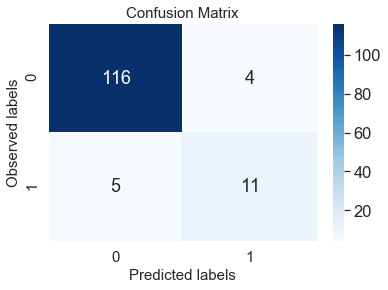

In [1501]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
label_font = {'size':'15'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'15'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
ax.xaxis.set_ticklabels(['0', '1']);
ax.yaxis.set_ticklabels(['0', '1']);
plt.show()


In [1516]:
def feature_importance():
    sns.set(font_scale=1.0)
    colnames = numcols+list(pipeline.transformers_[1][1].get_feature_names(catcols))
    pipedf=pd.DataFrame(data=X_train_prep, columns=colnames)
    plot = pd.Series(model.feature_importances_,index=pipedf.columns).sort_values().plot(kind='bar')
    return plot

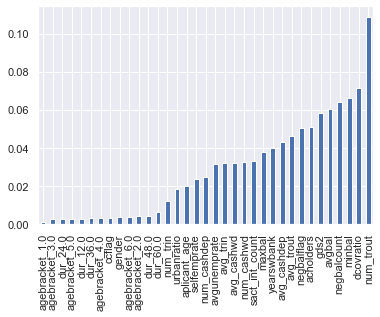

In [1517]:
feature_importance()

# GRIDSEARCH

In [1606]:
X = df.drop(columns=['status','loanpmt','avgsal','aplicant_age','gender'])
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_s, y_train_s = sampler(imputator(X_train), y_train)
X_test_imputed = imputator(X_test)

numpipe = Pipeline([
    ('scaler', MinMaxScaler())
])
numcols = X.drop(columns=['dur','agebracket']).columns.to_list()
catcols = ['dur','agebracket']
pipeline = ColumnTransformer([
        ('num',numpipe, numcols),
        ('cat',OneHotEncoder(), catcols)
])
X_train_prep = pipeline.fit_transform(X_train_s)
X_test_prep = pipeline.fit_transform(X_test_imputed)

In [1616]:
parameters = {'bootstrap':[True,False],'max_depth':list(range(2,20)),'max_features':['auto'],   
    'min_samples_leaf':[1,2,3,4],
    'min_samples_split':[2,3,4],
    'n_estimators':[50,100,150,200,400,500],
    'criterion': ['entropy','gini']
}

RF = RandomForestClassifier(class_weight='balanced')
RF = RandomizedSearchCV(estimator = RF,
                        param_distributions = parameters,
                        n_iter=100,
                        cv=5,
                        verbose=3,
                        random_state=42,
                        n_jobs=-1)

RF.fit(X_train_prep, y_train_s)

y_pred= RF.predict(X_test_prep)
print(classification_report(y_test,y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   58.7s finished


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       122
           1       0.90      0.60      0.72        15

    accuracy                           0.95       137
   macro avg       0.93      0.80      0.85       137
weighted avg       0.95      0.95      0.94       137



In [1612]:
from sklearn.model_selection import GridSearchCV
#DF
# parameters = {
#     'max_depth': list(range(2,20)),
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': range(1, 10),
#     'min_samples_leaf':[1,2,3,4]
# }
# RF
parameters = {
    'bootstrap':[True,False],
    'max_depth': list(range(2,20)),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': range(2, 10),
    'min_samples_leaf':[1,2,3,4],
    'class_weight':['balanced'],
    "max_features":['auto', 'sqrt', 'log2']
}
model = RF

# # GradientBoosint
# parameters = {
#     "loss":['exponential'],
#     "learning_rate": [0.01, 0.05, 0.1, 0.2],
#     "min_samples_split": [1,2,3],
#     "min_samples_leaf": [1,2,3],
#     "max_depth": list(range(3,10)),
#     "max_features":['auto'],
#     "criterion": ['friedman_mse', 'mse'],
#     "subsample":[ 0.8, 0.9, 1.0],
#     "n_estimators":[100,500,1000]
#     }


# model = GB

gs = GridSearchCV(model, parameters, scoring='recall', cv=5, n_jobs=-1, verbose=10)

gs.fit(X_train_prep, y_train_s)
y_pred= gs.predict(X_test_prep)
print(classification_report(y_test,y_pred))


Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

KeyboardInterrupt: 

In [1613]:
gs.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

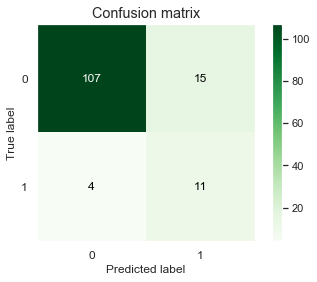

In [1609]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, title='Confusion matrix', labels=list(y_test.unique()),cmap='Greens')
plt.show()

In [692]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# FINALE


In [1599]:
X = df.drop(columns=['status','avgsal','loanpmt','aplicant_age','gender'])
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_s, y_train_s = sampler(imputator(X_train), y_train)
X_test_imputed = imputator(X_test)

In [1600]:
numpipe = Pipeline([
    ('scaler', MinMaxScaler())
])
numcols = X_train_s.drop(columns=['dur','agebracket']).columns.to_list()
catcols = ['dur','agebracket']
pipeline = ColumnTransformer([
        ('num',numpipe, numcols),
        ('cat',OneHotEncoder(), catcols)
])
X_train_prep = pipeline.fit_transform(X_train_s)
X_test_prep = pipeline.fit_transform(X_test_imputed)

In [1601]:
model = gs.best_estimator_
model.fit(X_train_prep,y_train_s)
y_pred= model.predict(X_test_prep)
accuracy_score(y_test, y_pred)

0.8905109489051095

In [1602]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94       122
           1       0.50      0.80      0.62        15

    accuracy                           0.89       137
   macro avg       0.74      0.85      0.78       137
weighted avg       0.92      0.89      0.90       137



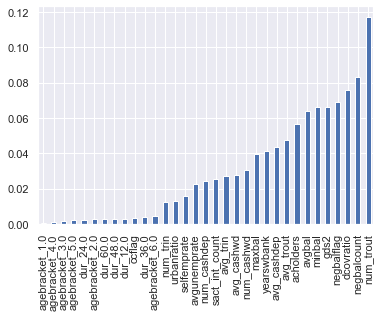

In [1603]:
feature_importance()